In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

In [306]:
!pip install pandas fiona shapely pyproj rtree
!pip install geopandas

import geopandas as gpd

In [307]:
fire_data = pd.read_csv("/content/telangana_fires.csv")

In [308]:
fire_data.head(4)

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,18.3777,80.5314,318.6,1.0,1.0,2015-01-02,802,Aqua,MODIS,69,6.03,302.6,7.7,D,0
1,17.5898,80.9893,315.4,1.2,1.1,2015-01-04,750,Aqua,MODIS,59,6.03,299.5,8.8,D,0
2,17.6028,81.1612,311.8,1.2,1.1,2015-01-05,527,Terra,MODIS,46,6.03,299.8,6.0,D,0
3,17.5241,80.3135,317.0,1.1,1.0,2015-01-05,527,Terra,MODIS,69,6.03,302.0,9.3,D,0


### Some approaches to find if the fires were agricultural or not:


*   Looking at the month of the year to see if we find any pattern.
As farming is seasonal, nature of fires due to it, should be periodic.

*   Looking at the time/ Day-Night during fire, This can help us get an idea if fire was lit during day, which should be the case for agricultural fires. There's a low probability of fire being lit at night by a person.

*   Look the spatial data for area under cultivation and find a relation between fires and agricultural land.    


In [309]:
import datetime
fire_month = pd.DatetimeIndex(fire_data["acq_date"]).month_name()
fire_month = fire_month.to_frame()
fire_month = fire_month.drop("acq_date", axis =1)

In [310]:
fire_month = fire_month.groupby("acq_date").size().reset_index(name ='firecases')

In [311]:
fire_month = fire_month.sort_values(by = "firecases", ascending= False)
fire_month["score"] = fire_month["firecases"]/fire_month["firecases"].sum()
fire_month

,acq_date,firecases,score
7,March,6571,0.349800
3,February,4171,0.222039
0,April,1762,0.093798
8,May,1485,0.079052
4,January,1484,0.078999
9,November,1176,0.062603
2,December,1171,0.062337
10,October,391,0.020814
6,June,260,0.013841
11,September,195,0.010381


Text(0.5, 0, 'months')

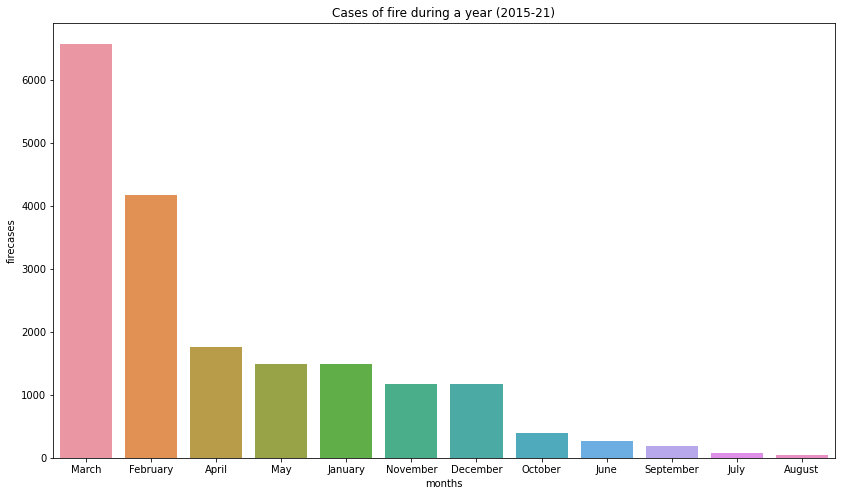

In [312]:
plt.figure(figsize= (14,8))
plt.title("Cases of fire during a year (2015-21)")
sns.barplot(data = fire_month, x = "acq_date", y = "firecases")
plt.xlabel("months")

We Observe that cases are very high during certain months during the year. 
March has 6000+ cases, comprising of ~30% of the total cases of fire.
Followed by Febraury, having 4000+ cases.
Combined they comprise of 56% cases reported.
This time is also the time for harvesting crops, **which suggests that these fires might be correlated.**

Text(0, 0.5, 'Fires caused')

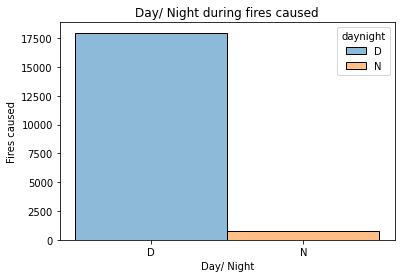

In [313]:
plt.title("Day/ Night during fires caused")
sns.histplot(data = fire_data, x= "daynight", hue ="daynight")
plt.xlabel("Day/ Night")
plt.ylabel("Fires caused")

We see a wide majority of fires (almost 97%) were caused during days.
Furthering our claim that Agriculture comprises of majority causes of fire.

In [314]:
fire_time = pd.cut(fire_data['acq_time'], bins=[0, 600 , 1200 , 1700, 2000, 2400], include_lowest=True, labels=['night', 'morning', 'afternoon', 'evening', 'night'], ordered=False)

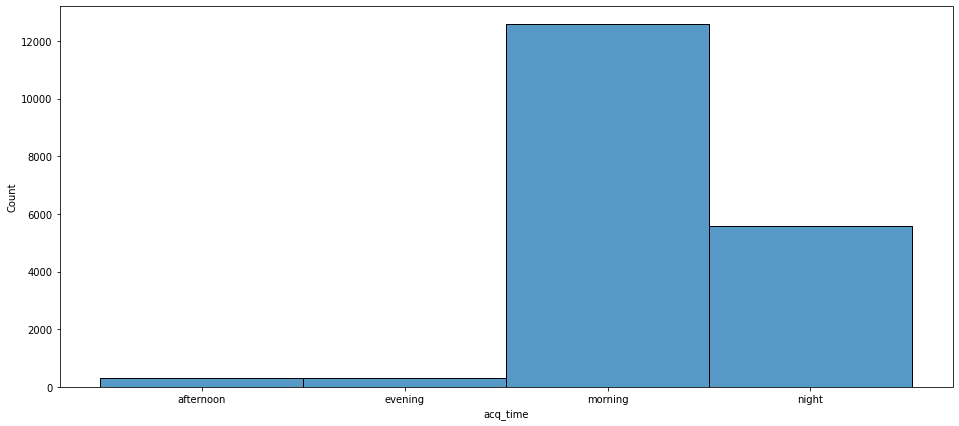

In [315]:
plt.figure(figsize= (16,7))
sns.histplot(data = fire_time)

Most fires are Morning fires. That means, It must have not been due to  heat waves causing fires during Summer afternoons.

Other approaches:


*   I couldn't find any Geospatial data that can clearly categorize Land use in Telangana's regions.

*   Although I found several images of various ESRI LULC map, We can train a neural network using deeplearning or simply super-pose images 
to use the map features to find the correlation and predict if fires are related to agriculture.
Intuition for using it is, images containing data as images of Forest cover can help us determine the reason for fire. since, fires in Forest may not be caused by agriculutural activities. 
Similarly, images of cities can help us determine, areas where fires weren't caused by agriculture. since, cities don't have much agriculture. & So on.

But, these approaches are time and effort consuming.
For this task, we'll use above observations to predict agricultural fires.


In [316]:
fire_data["acq_month"] = pd.DatetimeIndex(fire_data["acq_date"]).month_name()

In [317]:
fire_data["acq_time"] = pd.cut(fire_data['acq_time'], bins=[0, 600 , 1200 , 1700, 2000, 2400], include_lowest=True, labels=['night', 'morning', 'afternoon', 'evening', 'night'], ordered=False)

In [318]:
fire_data['fireID'] = pd.RangeIndex(1, 1 + len(fire_data))
useful_columns = ["fireID", "acq_month", "acq_time", "daynight"]
fire_data = fire_data[useful_columns]

In [319]:
len(fire_data)

18785

In [320]:
fire_data.head(3)

,fireID,acq_month,acq_time,daynight
0,1,January,morning,D
1,2,January,morning,D
2,3,January,night,D


In [321]:
month_scores = {"March": 0.349800,
                "February": 0.222039,
                "April": 0.093798,
                "May":0.079052,
                "January":0.078999,
                "November":0.062603,
                "December":0.062337,
                "October" : 0.020814,
                "June":0.013841,
                "September": 0.010381,
                "July" : 0.003833,
                "August" : 0.002502}

time_scores = { "morning" : 1,
                "afternoon": 0.5,
                "evening": 0.2,
                "night" : 0.1,
               "nan" : 0
}

for i in range(len(fire_data)) :
  fire_data.loc[i,"month_score"] = month_scores[fire_data.loc[i, "acq_month"]]


In [322]:
for i in range(len(fire_data)): 
  fire_data.loc[i,"time_score"] = time_scores[fire_data.loc[i,"acq_time"]]


fire_data["day_score"] = fire_data['daynight'].apply(lambda x: 1 if x == 'D' else 0)  

In [323]:
fire_data.head(3)

,fireID,acq_month,acq_time,daynight,month_score,time_score,day_score
0,1,January,morning,D,0.078999,1.0,1
1,2,January,morning,D,0.078999,1.0,1
2,3,January,night,D,0.078999,0.1,1


In [332]:
fire_data["probability(%)"] = 50*fire_data["month_score"]/fire_data["month_score"].max() + 35*fire_data["time_score"]/fire_data["time_score"].max() + 15*fire_data["day_score"]/fire_data["day_score"].max()

In [333]:
fire_data.sort_values(by="probability(%)" , ascending = False)

,fireID,acq_month,acq_time,daynight,month_score,time_score,day_score,probability,probability(%)
9392,9393,March,morning,D,0.349800,1.0,1,100.000000,100.000000
5845,5846,March,morning,D,0.349800,1.0,1,100.000000,100.000000
5869,5870,March,morning,D,0.349800,1.0,1,100.000000,100.000000
5868,5869,March,morning,D,0.349800,1.0,1,100.000000,100.000000
5867,5868,March,morning,D,0.349800,1.0,1,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...
6966,6967,September,evening,N,0.010381,0.2,0,8.483848,8.483848
7036,7037,October,night,N,0.020814,0.1,0,6.475129,6.475129
4079,4080,June,night,N,0.013841,0.1,0,5.478416,5.478416
6925,6926,June,night,N,0.013841,0.1,0,5.478416,5.478416


In [334]:
result_features = ["fireID", "probability(%)"]
result = fire_data[result_features]

In [335]:
result.head(5)

,fireID,probability(%)
0,1,61.292024
1,2,61.292024
2,3,29.792024
3,4,29.792024
4,5,61.292024


In [336]:
import json
result.to_json(r'/content/Task2_json.json', orient = 'split')